In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from SGanalysis.SGobject import SGobject 


from sklearn.cluster import AgglomerativeClustering as AggCluster

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools

In [1]:


# all_files = []

# # filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
# filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/'

# # roi_2
# roi_name = 'roi_2'

# for roi in [1,2,3]:
#     all_files.append(f'{filepath}roi_{roi_name})
                     
# all_files.append(')
    
### roi_name: [segmentation_file, spots_file, out_path]
roi_file_paths = {
    # 'roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/segmentations/nuclei_20240604_nuclei.tiff',
    #                        'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports/decode_20240604.csv',
    #                         'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports'
    #                        },
    #               'roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/segmentations/nuclei_20240529_nuclei.tiff',
    #                        'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports/decode_20240604.csv',
    #                         'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports'
    #                        },
    #               'roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/segmentations/nuclei_20240604_nuclei.tiff',
    #                        'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports/decode_20240604.csv',
    #                         'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports'
    #                        },
                #   'timezero':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/segmentations/segmentation_20240513_nuclei.tiff',
                #               # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                #               'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/transcripts/20240517_segmentation_withRefid.csv',
                #               'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/exports'
                #               },

                    'run2_roi_1':{'segmentation_file':'/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/decoded_data/2024-08-08_spatialbarcode_tumor2_projects/roi_1/exports/segmentation.tiff',
                                'spots_file':'/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/decoded_data/2024-08-08_spatialbarcode_tumor2_projects/roi_1/exports/transcripts.csv',
                                'out_path':'/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/processed_data/2024-08-08_spatialbarcode_tumor2/roi_1',
                                  },
                    'run2_roi_2':{'segmentation_file':'/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/decoded_data/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/segmentation.tiff',
                                'spots_file':'/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/decoded_data/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/transcripts.csv',
                                'out_path':'/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/processed_data/2024-08-08_spatialbarcode_tumor2/roi_2',
                                },
                    'run2_roi_3':{'segmentation_file':'/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/decoded_data/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/segmentation.tiff',
                                'spots_file':'/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/decoded_data/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/transcripts.csv',
                                'out_path':'/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/data/processed_data/2024-08-08_spatialbarcode_tumor2/roi_3',
                                },


        
                    # 'dish_roi2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/segmentations/segmentation_20240513_nuclei.tiff',
                    #           # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                    #           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/transcripts/20240517_segmentation_withRefid.csv',
                    #           'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/exports'
                    #           },
                  
                  }

In [3]:
out_path = roi_file_paths['run2_roi_1']['out_path']

In [4]:
with open(f'{out_path}/sg_object_dilate10_20240718.pkl', 'rb') as f:
        sg_obj = pickle.load(f)

In [6]:
matrix = sg_obj.get_cell_gene_table_df()

No filtering available or applied.


In [9]:
matrix['object_id'] = matrix.index

In [12]:
matrix = sg_obj.get_cell_gene_table_df()
matrix['object_id'] = [str(int(x)) for x in matrix.index]
matrix.set_index('object_id',inplace=True)

sg_obj.gdf['object_id'] = [str(int(x)) for x in sg_obj.gdf['object_id']]
sg_obj.gdf.set_index('object_id',inplace=True)

sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values
sg_obj.gdf['center_x'] = sg_obj.gdf['nucleus'].centroid.x.values
sg_obj.gdf['center_y'] = sg_obj.gdf['nucleus'].centroid.y.values
sg_obj.gdf['area'] = sg_obj.gdf['nucleus_dilated'].area.values

barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

No filtering available or applied.


In [16]:
cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
# df.set_index('object_id')

df = matrix
df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] >= cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)

In [17]:
df.to_csv(f'{out_path}/cell_by_gene_matrix_dilate10_withbarcodes_atleast{cutoff}.csv')

total_bc_threshold = 10

# include cells with at least 10 barcode spots
has_bcs = df[df[barcode_cols].sum(axis=1) >= 10]
matrix = has_bcs[barcode_cols]

print('Caluclating barcode distance matrices')

matrix_norm = matrix.div(matrix.sum(axis=1), axis=0)
braycurtis_dist = scipy.spatial.distance.pdist(matrix_norm,metric='braycurtis')

braycurtis_dist_square = scipy.spatial.distance.squareform(braycurtis_dist)

print('Distance computed! Proceding to clustering...')

threshold = 0.4
cluster = AggCluster(distance_threshold=threshold,n_clusters=None,linkage='average',affinity='precomputed').fit(braycurtis_dist_square)


gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])


cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes','area','center_x','center_y']
# for col in :
#     adata_genes.obs[col] = df[col]

adata_genes.obs = df[cols]


cluster_name_cutoff = 3

obj_clusters = {obj_id:clus for obj_id,clus in zip(matrix.index,cluster.labels_)}

cluster_objects = {}
cluster_barcode_names = {}
cluster_found_barcodes = {}
cluster_n_found_barcodes = {}

for clu in np.unique(cluster.labels_):
    cluster_objects[clu] = matrix.index[cluster.labels_ == clu]

    avg_bc_counts = np.mean(matrix[cluster.labels_ == clu],axis=0)
    # print(avg_bc_counts)
    # break

    found_bcs = []

    for bc in barcode_cols:
        if avg_bc_counts[bc] > cutoff:
            found_bcs.append(bc)

    print(clu,found_bcs)

    cluster_found_barcodes[clu] = found_bcs
    cluster_n_found_barcodes[clu] = len(found_bcs)

    cluster_barcode_names[clu] = '-'.join(sorted(found_bcs))

adata_genes.obs['bc_cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_n_bcs'] = [cluster_n_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_found_bcs'] = [cluster_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_bc_names'] = [cluster_barcode_names[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]

adata_genes.obs.to_csv(f'{out_path}/cell_by_gene_matrix_dilate10_withbarcodes_clustering_{total_bc_threshold}bcs_{threshold}thresh.csv')


Clustering barcodes...


: 

In [ ]:



# /roi_2


from SGanalysis.SGobject import SGobject

for roi_name,files in roi_file_paths.items():

    print(f'Processing {roi_name}...')

    segmentation_file = files['segmentation_file']
    spots_file = files['spots_file']
    out_path = files['out_path']

    # Create an instance of SGobject
    sg_obj = SGobject()

    # Convert a TIFF image to polygons and store them in a GeoDataFrame
    print("Running mask_to_objects...")
    sg_obj.mask_to_objects(segmentation_file)

    sg_obj.load_points(spots_file)

    sg_obj.dilate_objects(10)

    ## associate spots with segmentation

    sg_obj.create_cell_gene_table()

    with open(f'{out_path}/sg_object_dilate10_20240718.pkl', 'wb') as f:
        pickle.dump(sg_obj, f)

    matrix = sg_obj.get_cell_gene_table_df()
    matrix['object_id'] = [str(int(x)) for x in matrix.index]
    matrix.set_index('object_id',inplace=True)

    sg_obj.gdf['object_id'] = [str(int(x)) for x in sg_obj.gdf['object_id']]
    sg_obj.gdf.set_index('object_id',inplace=True)

    sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values
    sg_obj.gdf['center_x'] = sg_obj.gdf['nucleus'].centroid.x.values
    sg_obj.gdf['center_y'] = sg_obj.gdf['nucleus'].centroid.y.values
    sg_obj.gdf['area'] = sg_obj.gdf['nucleus_dilated'].area.values

    barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]


    ## traditional barcode calling (using cutoff of 3)

    cutoff = 3

    cell_barcodes = {}
    # matrix.set_index('object_id',   inplace=True)
    # df.set_index('object_id')

    df = matrix
    df['cell_id'] = df.index

    for cell_id in df['cell_id']:
        this_cell = df[df['cell_id']==cell_id]
        cell_barcodes[cell_id] = []

        for bc in barcode_cols:
            if this_cell[bc].values[0] >= cutoff:
                cell_barcodes[cell_id].append(bc)

    df['called_barcodes'] = cell_barcodes.values()
    df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
    df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

    df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)

    df.to_csv(f'{out_path}/cell_by_gene_matrix_dilate10_withbarcodes_atleast{cutoff}.csv')

    total_bc_threshold = 10

    # include cells with at least 10 barcode spots
    has_bcs = df[df[barcode_cols].sum(axis=1) >= 10]
    matrix = has_bcs[barcode_cols]

    print('Clustering barcodes...')

    matrix_norm = matrix.div(matrix.sum(axis=1), axis=0)
    braycurtis_dist = scipy.spatial.distance.pdist(matrix_norm,metric='braycurtis')

    braycurtis_dist_square = scipy.spatial.distance.squareform(braycurtis_dist)

    threshold = 0.4
    cluster = AggCluster(distance_threshold=threshold,n_clusters=None,linkage='average',affinity='precomputed').fit(braycurtis_dist_square)


    gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

    adata_genes = sc.AnnData(df[gene_cols])


    cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes','area','center_x','center_y']
    # for col in :
    #     adata_genes.obs[col] = df[col]

    adata_genes.obs = df[cols]


    cluster_name_cutoff = 3

    obj_clusters = {obj_id:clus for obj_id,clus in zip(matrix.index,cluster.labels_)}

    cluster_objects = {}
    cluster_barcode_names = {}
    cluster_found_barcodes = {}
    cluster_n_found_barcodes = {}

    for clu in np.unique(cluster.labels_):
        cluster_objects[clu] = matrix.index[cluster.labels_ == clu]

        avg_bc_counts = np.mean(matrix[cluster.labels_ == clu],axis=0)
        # print(avg_bc_counts)
        # break

        found_bcs = []

        for bc in barcode_cols:
            if avg_bc_counts[bc] > cutoff:
                found_bcs.append(bc)

        print(clu,found_bcs)

        cluster_found_barcodes[clu] = found_bcs
        cluster_n_found_barcodes[clu] = len(found_bcs)

        cluster_barcode_names[clu] = '-'.join(sorted(found_bcs))

    adata_genes.obs['bc_cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
    adata_genes.obs['bc_cluster_n_bcs'] = [cluster_n_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
    adata_genes.obs['bc_cluster_found_bcs'] = [cluster_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
    adata_genes.obs['bc_cluster_bc_names'] = [cluster_barcode_names[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]

    adata_genes.obs.to_csv(f'{out_path}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_{total_bc_threshold}bcs_{threshold}thresh.csv')


In [114]:
# number_of_barcodes 

n_cells = 500
n_bcs = 100
n_sisterhoods = 100

matrix = np.random.poisson(0.1,(n_cells,n_bcs))

sisterhoods = np.random.choice(n_cells,n_sisterhoods)

for cell in range(n_cells):
    if cell in sisterhoods:
        # overwrite the non-zero indices for this sisterhood
        non_zero_indices = np.random.choice(100,size=np.random.binomial(100,0.03),replace=False)

        matrix[cell,non_zero_indices] = np.random.poisson(10,len(non_zero_indices))
    else:
        # keep the non-zero indices for this cell
        matrix[cell,non_zero_indices] = np.random.poisson(10,len(non_zero_indices))


In [115]:
matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [116]:
dist=  scipy.spatial.distance.pdist(matrix,metric='braycurtis')
dist_square = scipy.spatial.distance.squareform(dist)

cluster = AggCluster(distance_threshold=0.6,n_clusters=None,linkage='average',affinity='precomputed').fit(dist_square)


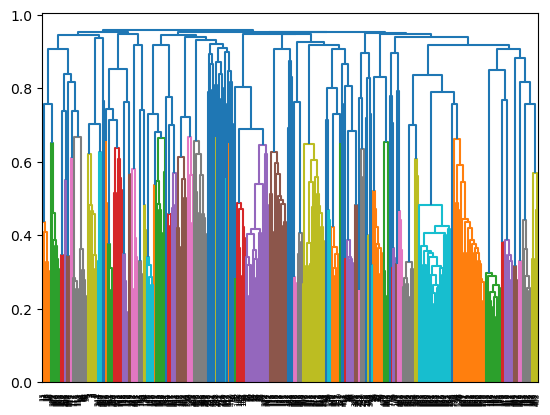

In [117]:
tools.plot_dendrogram(cluster)

In [118]:
len(np.unique(cluster.labels_))

122

In [126]:
dist_square

array([[0.        , 0.27272727, 0.35384615, ..., 0.93814433, 1.        ,
        0.93258427],
       [0.27272727, 0.        , 0.37142857, ..., 0.94117647, 0.97402597,
        0.9787234 ],
       [0.35384615, 0.37142857, 0.        , ..., 1.        , 0.96923077,
        1.        ],
       ...,
       [0.93814433, 0.94117647, 1.        , ..., 0.        , 0.73195876,
        0.94736842],
       [1.        , 0.97402597, 0.96923077, ..., 0.73195876, 0.        ,
        1.        ],
       [0.93258427, 0.9787234 , 1.        , ..., 0.94736842, 1.        ,
        0.        ]])

In [91]:
np.unique(cluster.labels_,return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [76]:
cluster.children_

array([[2844, 2997],
       [1970, 3155],
       [1271, 3751],
       ...,
       [9991, 9995],
       [9972, 9996],
       [3709, 9997]])